In [37]:
import matplotlib.pyplot as plt
import os
import torch
from typing import List
import pandas as pd
import gluonts

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 
import nnts.pandas
import nnts


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
data_path = "data"
model_name = "unrolled-future-covariate-lstm"
base_model_name = "base-lstm"
dataset_name = "tourism"
results_path = "ablation-results"
metadata_path = os.path.join(data_path, f"{base_model_name}-monash.json")
metadata = nnts.data.metadata.load(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.pandas.read_tsf(datafile_path)
params = nnts.models.Hyperparams()
splitter = nnts.pandas.LastHorizonSplitter()

nnts.loggers.makedirs_if_not_exists(PATH)

In [39]:
df_orig['month'] = df_orig['ds'].dt.month

In [40]:
class MaxMinScaler(nnts.data.preprocessing.Transformation):
    def __init__(self, max=None, min=None):
        self.max = max
        self.min = min

    def fit(self, data: pd.DataFrame, cols=None):
        numeric_data = data.select_dtypes(include=["number"])if cols is None else data[cols]
        self.max = numeric_data.max()
        self.min = numeric_data.min()
        return self

    def transform(self, data: pd.DataFrame, cols=None):
        numeric_data = data.select_dtypes(include=["number"]).columns if cols is None else data[cols]
        numeric_cols = numeric_data.columns
        data[numeric_cols] = (numeric_data - self.min) / (self.max - self.min)
        return data

    def inverse_transform(self, data: pd.DataFrame, cols=None):
        numeric_data = data.select_dtypes(include=["number"]) if cols is None else data[cols]
        numeric_cols = numeric_data.columns
        data[numeric_cols] = (
            numeric_data * (self.max - self.min) + self.min
        )
        return data

In [41]:
df_orig["unix_timestamp"] = (
    df_orig["ds"] - pd.Timestamp("1970-01-01")
) // pd.Timedelta("1s")

In [42]:
max_min_scaler = MaxMinScaler()
max_min_scaler.fit(df_orig, ["month", "unix_timestamp"])
df_orig = max_min_scaler.transform(df_orig, ["month", "unix_timestamp"])

In [43]:
metadata.freq

'M'

In [44]:
lag_seq = gluonts.time_feature.lag.get_lags_for_frequency(metadata.freq)

In [45]:
def prepare_lags(data, lag_seq):
    data = data.copy()
    conts = []
    for lag in lag_seq:
        data[f"y_lag_{lag}"] = (
            data[["y", "unique_id"]]
            .groupby("unique_id")
            .shift(lag)
            .bfill()
        )
        conts.append(f"y_lag_{lag}")
    return data, conts

In [46]:
df_orig, lag_conts = prepare_lags(df_orig, lag_seq)

In [47]:
scenario_list: List[nnts.experiments.Scenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.Scenario(
            metadata.prediction_length,
            conts= lag_conts + ["month", "unix_timestamp"],
            seed=seed,
        )
    )

In [48]:
scenario_list[0]

Scenario(prediction_length=24, conts=['month', 'unix_timestamp', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'y_lag_6', 'y_lag_7', 'y_lag_11', 'y_lag_12', 'y_lag_13', 'y_lag_23', 'y_lag_24', 'y_lag_25', 'y_lag_35', 'y_lag_36', 'y_lag_37'], seed=42, covariates=18)

In [49]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df = df_orig.copy()
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    logger = nnts.loggers.LocalFileRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH,
    )
    net = covs.model_factory(model_name, params, scenario, metadata)
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        os.path.join(PATH, f"{scenario.name}.pt"),
    )
    logger.configure(trner.events)

    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

UnrolledFutureCovariateLSTM(
  (decoder): UnrolledLSTMDecoder(
    (rnn): LSTM(20, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
)
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-18-pl-24-seed-42.pt
Epoch 1 train loss: 1902.1683349609375, valid loss: 5264.412109375
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-18-pl-24-seed-42.pt
Epoch 2 train loss: 742.3657836914062, valid loss: 5132.806640625
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-18-pl-24-seed-42.pt
Epoch 3 train loss: 634.3035278320312, valid loss: 5018.822265625
Artifact saved to ablation-results/unrolled-future-covariate-lstm/tourism/cov-18-pl-24-seed-42.pt
Epoch 4 train loss: 543.9767456054688, valid loss: 4601.270019531

KeyboardInterrupt: 

In [12]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [13]:
results = pd.read_csv(f"{PATH}/results.csv")
results

,input_dim,hidden_dim,n_layers,dropout,output_dim,batch_size,lr,epochs,patience,rnn_type,...,train_loss,valid_loss,mse,mae,mape,smape,abs_error,mase,rmse,run_time
0,1,40,2,0.1,1,128,0.001,100,10,lstm,...,15.016238,23.027124,4902.220703,21.491194,0.206207,0.180325,197804.937500,0.047054,25.892363,145.463297
1,1,40,2,0.1,1,128,0.001,100,10,lstm,...,13.192451,22.658005,4411.588379,21.094141,0.205757,0.179122,194150.468750,0.046184,25.324591,222.248479
2,1,40,2,0.1,1,128,0.001,100,10,lstm,...,12.632478,22.298548,4679.814941,21.292791,0.208612,0.180569,195978.859375,0.046619,25.651657,263.609132
3,1,40,2,0.1,1,128,0.001,100,10,lstm,...,13.177284,21.115871,4853.427734,21.804171,0.205996,0.179986,200685.562500,0.047739,26.193916,239.757288
4,1,40,2,0.1,1,128,0.001,100,10,lstm,...,14.764621,22.391037,4979.638184,21.591499,0.203067,0.179832,198728.171875,0.047273,25.923473,162.663356


/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/Users/garethdavies/Development/workspaces/nnts/projects/rnn-covariates/covs.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

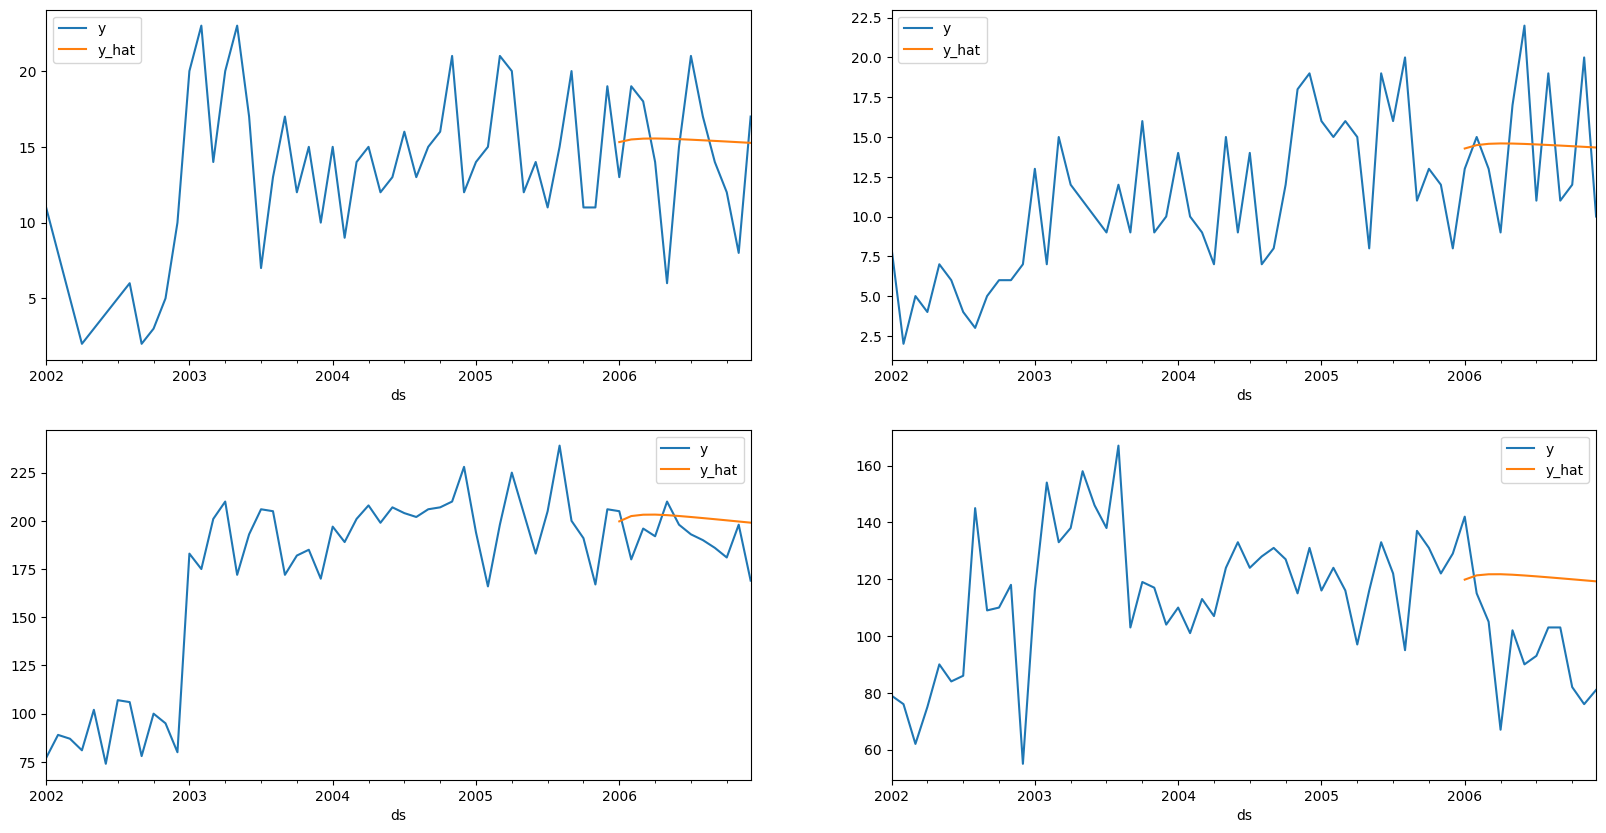

In [14]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

In [15]:
univariate_results = results.loc[
    (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mape", "rmse", "mae"],
]

univariate_results.mean(), univariate_results.std(), univariate_results.count()

(smape     0.179967
 mape      0.205928
 rmse     25.797200
 mae      21.454759
 dtype: float64,
 smape    0.000553
 mape     0.001968
 rmse     0.326698
 mae      0.273127
 dtype: float64,
 smape    5
 mape     5
 rmse     5
 mae      5
 dtype: int64)

In [ ]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]

In [ ]:
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.4714285714285714, 1.65])),
    cols,
].sort_values(by=['covariates', 'error'])

In [ ]:
sorted(results["error"].unique().tolist())

In [ ]:
import numpy as np
np.linspace(0, 0.6, 8).tolist()